In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import torch.nn as nn

from diffusers import (
    DiffusionPipeline,
    DDIMScheduler,
    DDPMScheduler,
    UNet2DConditionModel,
    AutoencoderKL,
)
from diffusers.utils import BaseOutput
from transformers import CLIPTextModel, CLIPTokenizer
num_train_timesteps=300
unet = UNet2DConditionModel(
).from_pretrained('./stable-diffusion-v1-5',
                  subfolder="unet",
                  in_channels=12,
                  out_channels=8,
                  low_cpu_mem_usage=False,
                  ignore_mismatched_sizes=True,
                  local_files_only = True)
vae = AutoencoderKL().from_pretrained('./stable-diffusion-v1-5',subfolder="vae")
scheduler = DDIMScheduler(num_train_timesteps=1000).from_pretrained('./stable-diffusion-v1-5',subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained('./stable-diffusion-v1-5',subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained('./stable-diffusion-v1-5',subfolder="text_encoder")
# device = 'cuda'
# vae.requires_grad_(False)
# unet.requires_grad_(True)
# text_encoder.requires_grad_(False)
# text_encoder.text_model.embeddings.token_embedding.requires_grad_(False)
# # tokenizer.requires_grad_(False)

# vae.eval()
# text_encoder.text_model.embeddings.token_embedding.eval()
# text_encoder.eval()
# unet.train()

# vae.to(device)
# unet.to(device)
class FinetuneUnet(nn.Module):
    rgb_latent_scale_factor = 0.18215
    depth_latent_scale_factor = 0.18215
    def __init__(
            self,
            unet: unet,
            vae: AutoencoderKL,
            scheduler: DDIMScheduler,
            text_encoder: CLIPTextModel,
            tokenizer: CLIPTokenizer,
    ):
        super(FinetuneUnet, self).__init__()
        self.unet = unet
        self.vae = vae
        self.scheduler = scheduler
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.empty_text_embed = None

    def __encode_empty_text(self):
        """
        Encode text embedding for empty prompt
        """
        prompt = ""
        text_inputs = self.tokenizer(
            "",
            padding="do_not_pad",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids.to(self.text_encoder.device)
        self.empty_text_embed = self.text_encoder(text_input_ids)[0].to(torch.float32)

    def encode_3c(self, render: torch.Tensor) -> torch.Tensor:
        # encode
        h = self.vae.encoder(render)
        moments = self.vae.quant_conv(h)
        mean, logvar = torch.chunk(moments, 2, dim=1)
        # scale latent
        render_latent = mean * self.rgb_latent_scale_factor
        return render_latent

    def forward(self,render_depth_normal_latent):
        device = render_depth_normal_latent.device

        render_latent = render_depth_normal_latent[:,0:4,:,:]
        depth_normal_latent = render_depth_normal_latent[:,4:12,:,:]

        # noise is 8 channel
        noise = torch.randn((render_latent.shape[0],8,render_latent.shape[2],render_latent.shape[3]), device=device) # noise for depth_normal_latent
        bs = render_latent.shape[0]
        timesteps = torch.randint(
            0, self.scheduler.config.num_train_timesteps, (bs,), device=device,
            dtype=torch.int64
        )
        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_depth_normal = self.scheduler.add_noise(depth_normal_latent, noise, timesteps)

        # empty text embedding
        if self.empty_text_embed is None:
            self.__encode_empty_text()
        batch_empty_text_embed = self.empty_text_embed.repeat(
            (render_latent.shape[0], 1, 1)
        )  # [B, 2, 1024]

        unet_input = torch.cat([render_latent,noisy_depth_normal],dim=1)
        pred_noise = self.unet(unet_input,timesteps,encoder_hidden_states=batch_empty_text_embed).sample
        return pred_noise, noise

/home/boom/anaconda3/envs/marigold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of UNet2DConditionModel were not initialized from the model checkpoint at ./stable-diffusion-v1-5 and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 12, 3, 3]) in the model instantiated
- conv_out.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([8]) in the model instantiated
- conv_out.weight: found shape torch.Size([4, 320, 3, 3]) in the checkpoint and torch.Size([8, 320, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
device = 'cuda'
vae.requires_grad_(False)
unet.requires_grad_(True)
text_encoder.requires_grad_(False)
text_encoder.text_model.embeddings.token_embedding.requires_grad_(False)

vae.eval()
text_encoder.text_model.embeddings.token_embedding.eval()
text_encoder.eval()
unet.train()

vae.to(device)
unet.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(12, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=32

In [3]:
device = "cuda"
model = FinetuneUnet(unet=unet, vae=vae, scheduler=scheduler, text_encoder=text_encoder, tokenizer=tokenizer)
model = model.to(device)

In [6]:
render = np.load('./render_depth_normal_latent.npy').astype(np.float32)
print(render.shape)
# render = render.transpose(0, 3, 1, 2)
print(render.shape)
# data = render[0:5000]
data = render
# data = np.concatenate([render,render,render],axis=1)
print(data.shape)
print(type(data[0][1][1][1]))

(1000, 12, 32, 32)
(1000, 12, 32, 32)
(1000, 12, 32, 32)
<class 'numpy.float32'>


In [5]:

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=3,
    shuffle=True,
    drop_last=True,
)
len(loader), next(iter(loader)).shape

(333, torch.Size([3, 12, 32, 32]))

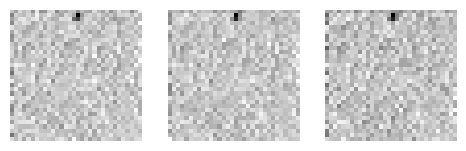

In [17]:
def show(images,save=False,name='default'):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(20, 10))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        # image = (image + 1) / 2
        if image.shape[2] == 1:
            plt.subplot(5, 10, i + 1)
            plt.imshow(image,cmap='gray')
            plt.axis('off')
            
        else:
            plt.subplot(5, 10, i + 1)
            plt.imshow(image)
            plt.axis('off')
    if save:
        plt.savefig(f'{name}.pdf') 

    plt.show()

def show_error_map(pred, gd, save=False,name='default'):
    # Ensure the tensors have the same shape
    assert pred.shape == gd.shape, "Input tensors must have the same shape"
    pred = pred.mean(dim=1, keepdim=True)
    gd = gd.mean(dim=1, keepdim=True)
    # Calculate the absolute difference between the prediction and ground truth
    error_map = torch.abs(pred - gd) * 10
    show(error_map,save,name)
show(next(iter(loader))[:,2:3,:,:])

In [18]:
next(iter(loader)).shape

torch.Size([3, 12, 32, 32])

In [19]:
from skimage.metrics import structural_similarity as ssim
def ssim_loss(data,pred):
    ssim_values = 0.0  # Initialize a variable to accumulate SSIM values
    # Loop through the batch of images
    data = data.detach().cpu().numpy().transpose(0, 2, 3, 1)
    pred = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
    for i in range(data.shape[0]):
        # Calculate SSIM between original and reconstructed image
        # ssim_val = ssim(upscaled_img1, upscaled_img2, multichannel=True, channel_axis=2)
        ssim_val = ssim(data[i], pred[i], multichannel=True, data_range=data[i].max()-data[i].min())
        ssim_values += ssim_val
    
    # Compute the average SSIM across all images in the batch
    average_ssim = ssim_values / data.shape[0]
    loss = 1 - average_ssim
    return loss

In [ ]:
# from skimage.metrics import structural_similarity as ssim
# def train():
#     criterion = torch.nn.L1Loss()
#     optimizer = torch.optim.AdamW(model.parameters(),
#                                   lr=1e-5,                   
#                                   weight_decay=1e-4)
#     model.to(device)
#     model.train()

#     accu_loss  = 0
#     total_loss = 0 
#     for epoch in range(2000):
#         for i, data in enumerate(loader):
#             pred_noise, noise = model(data.to(device))
#             loss = criterion(pred_noise, noise)
#             loss = loss + 5 * ssim_loss(pred_noise, noise)
#             accu_loss += loss
#             total_loss += loss
#             if (i+1) % 8 == 0:
#                 accu_loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#                 optimizer.step()
#                 optimizer.zero_grad()
#                 print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(loader)}, Loss: {accu_loss.item():.4f}", end='\r')
#                 accu_loss = 0
#             torch.cuda.empty_cache()
#         if epoch % 1 == 0:
#             print(epoch, total_loss)
#             total_loss = 0
#             # model.eval()
#             # show(generate(10, device))
#             # model.train()
#             torch.save(unet.state_dict(), './unet_finetune.pth')

# train()

In [20]:
from skimage.metrics import structural_similarity as ssim
def train():
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=4e-5,                   
                                  weight_decay=1e-4)
    model.to(device)
    model.train()

    loss_sum = 0
    for epoch in range(1000):
        for i, data in enumerate(loader):
            pred_noise, noise = model(data.to(device))
            loss = criterion(pred_noise, noise)
            # loss = loss + 1 * ssim_loss(pred_noise, noise)

            loss.backward()
            loss_sum += loss.item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
            print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(loader)}, Loss: {loss.item():.4f}", end='\r')
        if epoch % 1 == 0:
            print(epoch, loss_sum, loss_sum/1000)
            loss_sum = 0
            # model.eval()
            #show(generate(10, device))
            # model.train()
            torch.save(model.state_dict(), './unet_finetune.pth')

train()

0 142.72917690873146 0.14272917690873146
1 48.04192288964987 0.04804192288964987
2 37.251867569983006 0.037251867569983006
3 30.877938348799944 0.030877938348799944
4 27.973741300404072 0.027973741300404073
5 25.341458212584257 0.025341458212584256
6 25.440560776740313 0.025440560776740312
7 24.248304419219494 0.024248304419219494
8 22.861088152974844 0.022861088152974843
9 23.587552811950445 0.023587552811950446
10 23.94608622789383 0.02394608622789383
11 22.565422037616372 0.022565422037616373
12 20.96161136776209 0.02096161136776209
13 21.228751327842474 0.021228751327842472
14 20.451470382511616 0.020451470382511616
15 20.962827725335956 0.020962827725335954
16 20.91096622683108 0.020910966226831078
17 19.373019525781274 0.019373019525781274
18 18.289206640794873 0.018289206640794874
19 18.189612183719873 0.018189612183719873
20 18.778424635529518 0.01877842463552952
21 17.22875402122736 0.01722875402122736
22 17.78722302056849 0.01778722302056849
23 17.66657606512308 0.01766657606

KeyboardInterrupt: 

: 

In [ ]:
# ssim_values = 0.0  # Initialize a variable to accumulate SSIM values
            # # Loop through the batch of images
            # data = data.detach().cpu().numpy().transpose(0, 2, 3, 1)
            # pred = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
            # for i in range(data.shape[0]):
            #     # Calculate SSIM between original and reconstructed image
                
            #     # ssim_val = ssim(upscaled_img1, upscaled_img2, multichannel=True, channel_axis=2)
            #     ssim_val = ssim(data[i], pred[i], multichannel=True)
            #     ssim_values += ssim_val
            
            # # Compute the average SSIM across all images in the batch
            # average_ssim = ssim_values / data.shape[0]
            # loss = 1 * loss + 0 * (1 - average_ssim)

In [ ]:
# criterion = torch.nn.L1Loss()
# optimizer = torch.optim.AdamW(model.parameters(),
#                                   lr=5e-5,
#                                   weight_decay=1e-4)
# def train():
#     for epoch in range(2000):
#         for i, data in enumerate(loader):
            
#             pred_noise, noise = model(data.to(device))

#             optimizer.zero_grad()
#             loss = criterion(pred_noise, noise)
#             loss.backward()
#             optimizer.step()
            
#             print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(loader)}, Loss: {loss.item():.4f}", end='\r')
#         torch.save(model.state_dict(), './unet_finetune.pth')


# train()

# ------------------------------------------TEST CODE -----------------------------------------------------

In [ ]:
# model = model.to(device)
# model.eval()
# unet = model.unet

In [ ]:
# print(data.shape)
# data = data[0:4,:,:,:]
# data = torch.from_numpy(data).to(device)
# print(data.shape)

In [ ]:
# pred_noise, noise = model(data)
# print(pred_noise.shape)

In [ ]:
# depth_latent = pred_noise[:,0:4,:,:]
# depth_latent.shape
# output_tensor = torch.mean(depth_latent, dim=1, keepdim=True)

In [ ]:
show(output_tensor)

In [ ]:
# rgb_latent_scale_factor = 0.18215
# depth_latent_scale_factor = 0.18215
# def encode_3c(render: torch.Tensor) -> torch.Tensor:
#         # encode
#         h = vae.encoder(render)
#         moments = vae.quant_conv(h)
#         mean, logvar = torch.chunk(moments, 2, dim=1)
#         # scale latent
#         render_latent = mean * rgb_latent_scale_factor
#         return render_latent

In [ ]:
# render = np.load('./render.npy').astype(np.float32)

In [ ]:
# print(render.shape)
# render = render.transpose(0,3,1,2)
# render = torch.from_numpy(render).cuda()
# print(render.shape)

In [ ]:
# vae = vae.cuda()
# out = encode_3c(render[3:7])
# print(out.shape)

In [ ]:
# from tqdm import tqdm
# data_all = np.empty((5400,4,32,32),np.float32)
# for i in tqdm(range(data_all.shape[0])):
#     out = encode_3c(render[i:i+1])
#     data_all[i] = out.detach().cpu().numpy()

In [ ]:
# render_depth_normal_latent = np.concatenate([data_all,data_all,data_all],axis=1)
# render_depth_normal_latent.shape

In [ ]:
# np.save('./render_depth_normal_latet.npy',render_depth_normal_latent)